# 6. ADI forward modeling of disks

> Author: *Julien Milli*  
> Last update: *23/03/2022*  
> Suitable for VIP *v1.0.0* onwards.

**Table of contents**

* [6.1. Introduction](#6.1.-Introduction)
    - [6.1.1. Overview](#6.1.1.-Overview)
    - [6.1.2. Parametrisation of the density distribution of dust](#6.1.2.-Parametrisation-of-the-density-distribution-of-dust)
    
* [6.2. Examples of disks](#6.2.-Examples-of-disks)
    - [6.2.1. Symmetric pole-on disk](#6.2.1.-Symmetric-pole-on-disk)
    - [6.2.2. Inclined symmetric disk](#6.2.2.-Inclined-symmetric-disk)
    - [6.2.3. Inclined symmetric disk with anisotropy of scattering](#6.2.2.-Inclined-symmetric-disk-with-anisotropy-of-scattering)
        - [6.2.3.1. Simple Henyey-Greenstein phase function](#6.2.3.1.-Simple-Henyey-Greenstein-phase-function)
        - [6.2.3.2. Double Henyey-Greenstein phase function](#6.2.3.2.-Double-Henyey-Greenstein-phase-function)
        - [6.2.3.3. Custom phase function](#6.2.3.3.-Custom-phase-function)    
        - [6.2.3.4. Representing a polarised phase function](#6.2.3.4.-Representing-a-polarised-phase-function)    
    - [6.2.4. Asymmetric disk](#6.2.4.-Asymmetric-disk)
    
* [6.3. Forward modeling of disks](#5.3.-Forward-modeling-of-disks)

This tutorial shows:

- how to generate different models of synthetic (debris) disks;
- how to inject model disks in ADI cubes, for forward modeling.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import time_ini, timing
    from vip_hci.medsub import median_sub
    from vip_hci.metrics import cube_inject_fakedisk, ScatteredLightDisk
else:
    from vip_hci.config import time_ini, timing
    from vip_hci.fm import cube_inject_fakedisk, ScatteredLightDisk
    from vip_hci.psfsub import median_sub
# common to all versions:
from vip_hci.var import create_synth_psf

VIP version:  1.4.0


## 6.1. Introduction

### 6.1.1. Overview

The functions implemented in vip_hci for disks are located in `vip.metrics.scattered_light_disk`. It contains the definition of a class called `ScatteredLightDisk` which can produce a synthetic image of a disk, and also utility functions to create cubes of images where a synthetic disk has been injected at specific position angles to simulate a real observation. 

Currently there is no utility function to do forward modelling and try to find the best disk matching a given dataset as this is usually specific to each dataset.

Keep in mind that `ScatteredLightDisk` is only a ray-tracing approach and does not contain any physics in it (no radiative transfer, no particle cross-section). It assumes the particles number density around a star follows the mathematical prescription given in section 1.2 and uses a unity scattering cross-section for all particles (no particle size distribution and cross-section dependant on the particle size, the flux of the synthetic disk cannot be converted in physical units (e.g. Jy)

### 6.1.2. Parametrisation of the density distribution of dust

The density distribution of dust particles is parametrized in a cylindrical coordinate system $\rho(r,\theta,z)$ and is described by the equation:

$\rho(r,\theta,z) = \rho_0 \times \left( \frac{2}{\left( \frac{r}{R(\theta)} \right)^{-2a_{in}} + \left( \frac{r}{R(\theta)} \right)^{-2a_{out}} }\right)^{1/2} \times e^{\left[ -\left( \frac{z}{H(r) }\right)^\gamma \right]}$

where $R(\theta)$ is called the reference radius. It is simply the radius of the disk $a$ if the dust distribution is centrally symmetric (no eccentricity). If the disk is eccentric, then $R(\theta)$ depends on $\theta$ and is given by the equation of an ellipse in polar coordinates: $R(\theta) = \frac{a(1-e^2)}{1+e \cos{\theta}}$

This equation for $\rho(r,\theta,z)$ is the product of 3 terms:
1. a constant $\rho_0$ which is the surfacce density of the dust in the midplane, at the reference radius $R(\theta)$. 
2. the density distribution in the midplane $z=0$ defined as $\left( \frac{2}{\left( \frac{r}{R(\theta)} \right)^{-2a_{in}} + \left( \frac{r}{R(\theta)} \right)^{-2a_{out}} }\right)^{1/2}$. Such a function ensures that when $r\ll R(\theta)$ then the term is $\propto r^{\alpha_{in}}$ (and we typically use $\alpha_{in}>0$) and when $r\gg R(\theta)$ then the term is $\propto r^{\alpha_{out}}$ (and we typically use $\alpha_{out}<0$).
3. the vertical profile $e^{\left[ -\left( \frac{z}{H(r) }\right)^\gamma \right]}$ is parametrized by an exponential decay of exponent $\gamma$ and scale height $H(r)$. If $\gamma=2$, the vertical profile is Gaussian (and $H(r)$ is proportional to the $\sigma$ or FWHM of the Gaussian (but not strictly equal to any of them). The scale height is further defined as $H(r)=\xi_0 \times \left( \frac{r}{R(\theta)} \right)^\beta$ where $\xi_0$ is the reference scale height at the reference radius $R(\theta)$ and $\beta$ is the flaring coeffient ($\beta=1$ means a linear flaring: the scale height increases linearly with radius).

## 6.2. Examples of disks

Let's assume we want to create a synthetic image of 200px, containing a disk around a star located at 80 a.u., observed with SPHERE/IRDIS (pixel scale 12.25 mas).

In [3]:
pixel_scale=0.01225 # pixel scale in arcsec/px
dstar= 80 # distance to the star in pc
nx = 200 # number of pixels of your image in X
ny = 200 # number of pixels of your image in Y

### 6.2.1. Symmetric pole-on disk

For a pole-on disk, $i_\text{tilt}=0^\circ$.

For a symmetric disk, $e=0$ and the position angle (pa) and argument of pericenter ($\omega$) have no impact.

We choose a semi-major axis of 70 a.u., a vertical profile with a gaussian distribution ($\gamma=2$), a reference scale height of 3 a.u. at the semi-major axis of the disk, and inner and outer exponent $\alpha_{in}=12$ and $\alpha_{out}=-12$

In [4]:
itilt = 0. # inclination of your disk in degrees
a = 70. # semimajoraxis of the disk in au 
ksi0 = 3. # reference scale height at the semi-major axis of the disk
gamma = 2. # exponant of the vertical exponential decay
alpha_in = 12
alpha_out = -12
beta = 1

Then create your disk model

In [5]:
fake_disk1 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'HG', 'g':0., 'polar':False}, 
                                flux_max=1.)

The method `compute_scattered_light` returns the synthetic image of the disk.

In [6]:
fake_disk1_map = fake_disk1.compute_scattered_light()

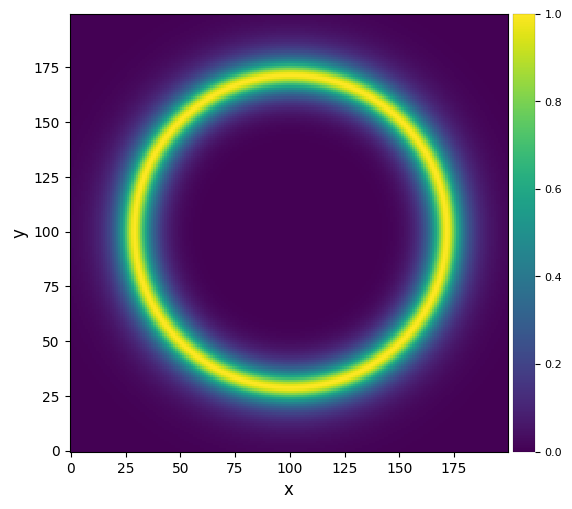

In [7]:
plot_frames(fake_disk1_map, grid=False, size_factor=6)

You can print some info on the geometrical properties of the model, the dust distribution parameters, the numerical integration parameters and the phase function parameters (detailed later). 

This can be useful because, in addition to reminding all the parameters used in the model, it also computes some properties such as the radial FWHM of the disk.

In [8]:
fake_disk1.print_info()

-----------------------------------
Geometrical properties of the image
-----------------------------------
Image size: 200 px by 200 px
Pixel size: 0.0123 arcsec/px or 0.98 au/px
Distance of the star 80.0 pc
From -98.0 au to 97.0 au in X
From -98.0 au to 97.0 au in Y
Position angle of the disc: 0.00 degrees
Inclination 0.00 degrees
Argument of pericenter 0.00 degrees
Maximum flux of the disk 1.00
----------------------------
Dust distribution parameters
----------------------------
Reference semi-major axis: 70.0au
Semi-major axis at maximum dust density in plane z=0: 70.0au (same as ref sma if ain=-aout)
Semi-major axis at half max dust density: 64.2au / 76.3au for the inner/outer edge, or a FWHM of 12.1au
Semi-major axis at maximum dust surface density: 70.2au (same as ref sma if ain=-aout)
Ellipse p parameter: 70.0au
Ellipticity: 0.000
Inner slope: 12.00
Outer slope: -12.00
Density at the reference semi-major axis: 1.000e+00 (arbitrary unit
Scale height: 3.00 au at 70.00
Vertical p

As a side note, if $\alpha_{in} \ne \alpha_{out}$, then the peak surface density of the disk is not located at the reference radius $a$.

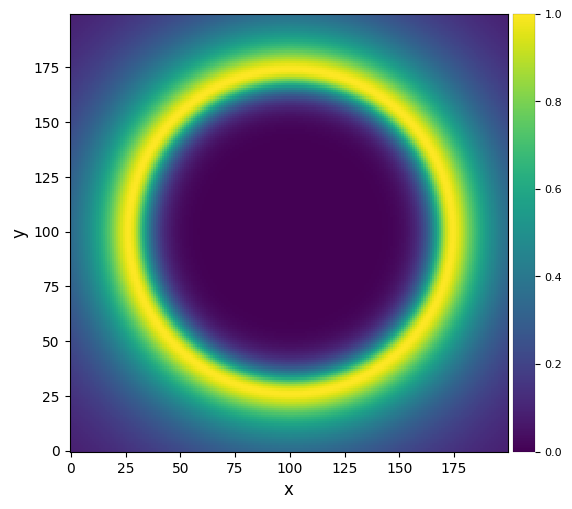

In [9]:
fake_disk1 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':-3,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':0., 'polar':False},
                                flux_max=1.)
fake_disk1_map = fake_disk1.compute_scattered_light()
plot_frames(fake_disk1_map, grid=False, size_factor=6)

In [10]:
fake_disk1.print_info()

-----------------------------------
Geometrical properties of the image
-----------------------------------
Image size: 200 px by 200 px
Pixel size: 0.0123 arcsec/px or 0.98 au/px
Distance of the star 80.0 pc
From -98.0 au to 97.0 au in X
From -98.0 au to 97.0 au in Y
Position angle of the disc: 0.00 degrees
Inclination 0.00 degrees
Argument of pericenter 0.00 degrees
Maximum flux of the disk 1.00
----------------------------
Dust distribution parameters
----------------------------
Reference semi-major axis: 70.0au
Semi-major axis at maximum dust density in plane z=0: 73.3au (same as ref sma if ain=-aout)
Semi-major axis at half max dust density: 65.0au / 95.9au for the inner/outer edge, or a FWHM of 30.9au
Semi-major axis at maximum dust surface density: 74.5au (same as ref sma if ain=-aout)
Ellipse p parameter: 70.0au
Ellipticity: 0.000
Inner slope: 12.00
Outer slope: -3.00
Density at the reference semi-major axis: 1.000e+00 (arbitrary unit
Scale height: 3.00 au at 70.00
Vertical pr

### 6.2.2. Inclined symmetric disk

In [11]:
itilt = 76 # inclination of your disk in degreess

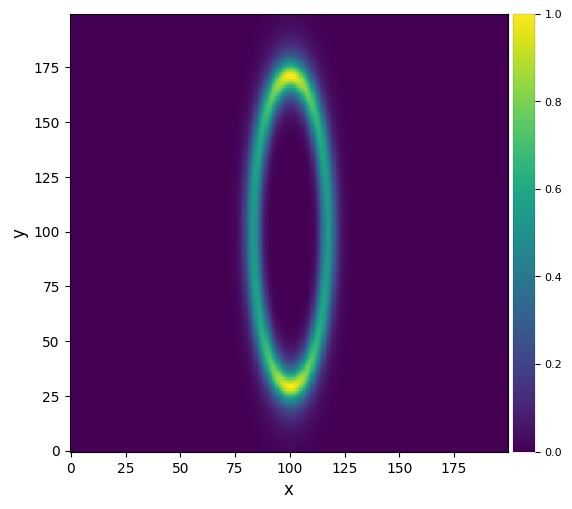

In [12]:
fake_disk2 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':0., 'polar':False},
                                flux_max=1.)
fake_disk2_map = fake_disk2.compute_scattered_light()
plot_frames(fake_disk2_map, grid=False, size_factor=6)

The position angle of the disk is 0 (e.g. north).  The phase function is asymmetric, the reason why the north and south ansae appear brighter is because the disk is not flat: it has a certain scale height and there is more dust intercepted along the line of sight in the ansae.

Note that we decided here to normalize the disk to a maximum brightness of 1, using the option `flux_max=1.`. This is not the only option available and you can decide to paramterize $\rho_0$ instead, using the keyword `dens_at_r0` which directly specifies $\rho_0$.

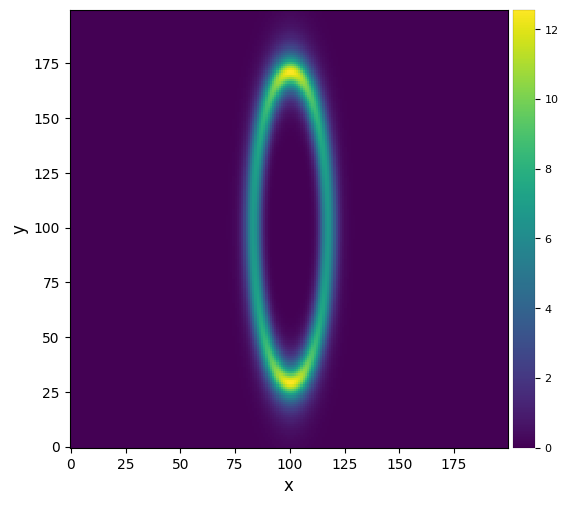

In [13]:
fake_disk2 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta,
                                              'dens_at_r0':1e6},
                                spf_dico={'name':'HG', 'g':0, 'polar':False})
fake_disk2_map = fake_disk2.compute_scattered_light()
plot_frames(fake_disk2_map, grid=False, size_factor=6)

Warning ! The code does not handle perfectly edge-on disks. There is a maximum inclination close to edge-on beyond which it cannot create an image. In practice this is not a limitation as the convolution by the PSF always makes it impossible to disentangle between a close to edge-on disk and a perfectly edge-on disk.

Warning the disk is too close to edge-on
The inclination was changed from 90.00 to 87.58


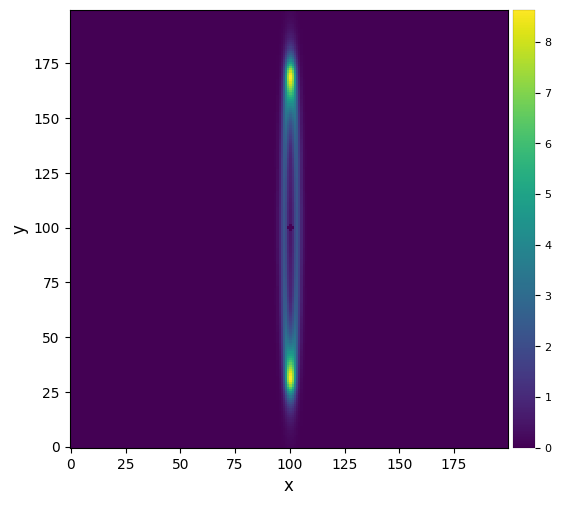

In [14]:
fake_disk2 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=90, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':2, 'gamma':gamma, 'beta':beta, 
                                              'dens_at_r0':1e6},
                                spf_dico={'name':'HG', 'g':0, 'polar':False})
fake_disk2_map = fake_disk2.compute_scattered_light()
plot_frames(fake_disk2_map, grid=False, size_factor=6)

### 6.2.3. Inclined symmetric disk with anisotropy of scattering

#### 6.2.3.1. Simple Henyey-Greenstein phase function

We parametrize the phase function by a Henyey Greenstein phase function, with an asymmetry parameter g. An isotropic phase function has $g=0$, forward scattering is represented by $0<g\leq1$ and backward scattering is represented by $-1\leq g<0$

In [15]:
g=0.4

In [16]:
fake_disk3 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':g, 'polar':False},
                                flux_max=1.)

You can plot how the phase function look like:

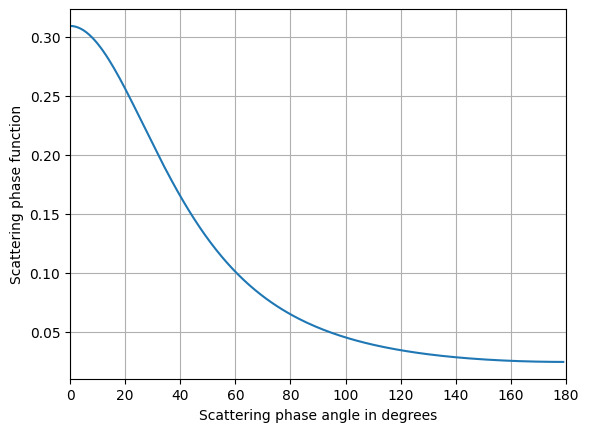

In [17]:
fake_disk3.phase_function.plot_phase_function()

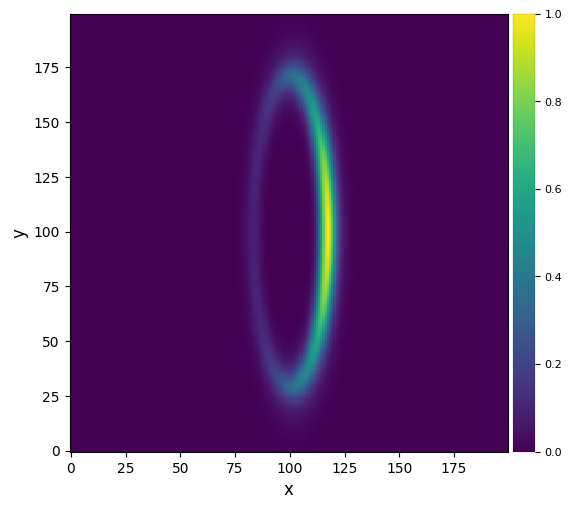

In [18]:
fake_disk3_map = fake_disk3.compute_scattered_light()
plot_frames(fake_disk3_map, grid=False, size_factor=6)

The forward side is brighter. 

#### 6.2.3.2. Double Henyey-Greenstein phase function

A double Henyey Greenstein (HG) phase function is simply a linear combination of 2 simple HG phase function. It is therefore parametrized by $g_1$ and $g_2$ the 2 asymmetry parameters of each HG and the weight (between 0 and 1) of the first HG phase function. Typically a double HG is used to represent a combination of forward scattering ($g_1>0$) and backward scattering ($g_2<1$)

In [19]:
g1=0.6
g2=-0.4
weight1=0.7

In [20]:
fake_disk4 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1,
                                          'polar':False},
                                flux_max=1)

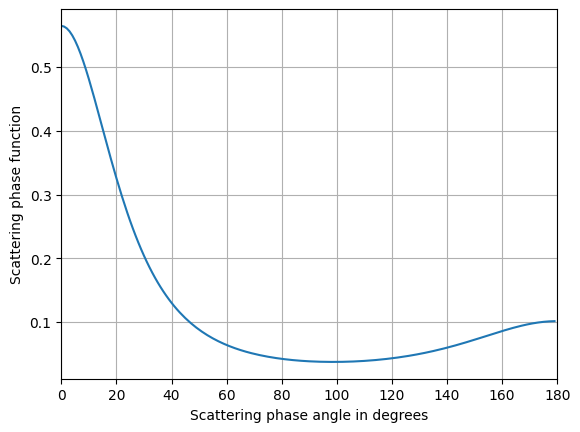

In [21]:
fake_disk4.phase_function.plot_phase_function()

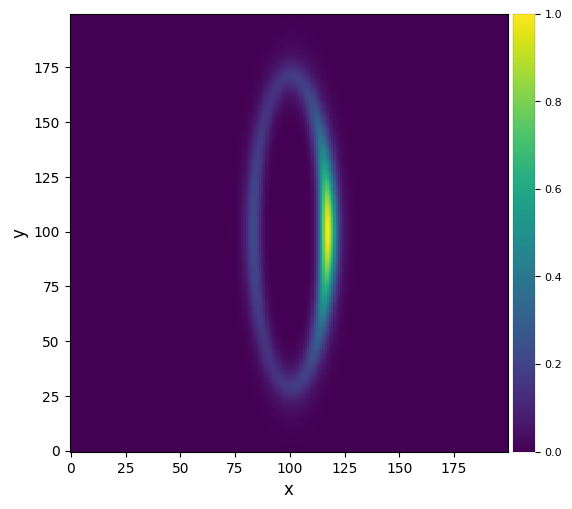

In [22]:
fake_disk4_map = fake_disk4.compute_scattered_light()
plot_frames(fake_disk4_map, grid=False, size_factor=6)

#### 6.2.3.3. Custom phase function

In some cases, a HG phase function (simple or double) cannot represent well the behaviour of the dust. The code is modular and you can propose new prescriptions for the phase functions if you need, or you can also create a custom phase function.

In [23]:
kind='cubic' #kind must be either "linear", "nearest", "zero", "slinear", "quadratic" or "cubic"
spf_dico = dict({'phi':[0,  60,  90, 120, 180],
                 'spf':[1, 0.4, 0.3, 0.3, 0.5],
                 'name':'interpolated', 'polar':False, 'kind':kind})

In [24]:
fake_disk5 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico=spf_dico, flux_max=1)

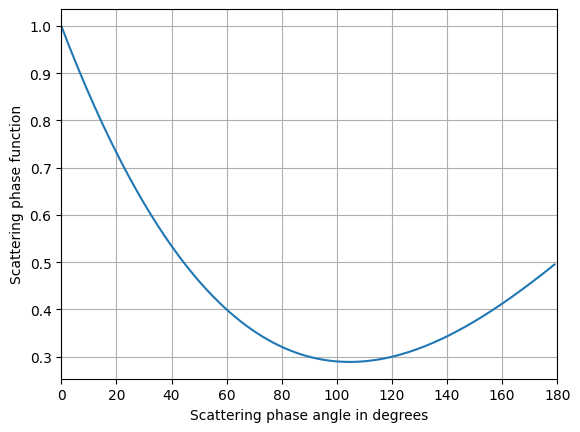

In [25]:
fake_disk5.phase_function.plot_phase_function()

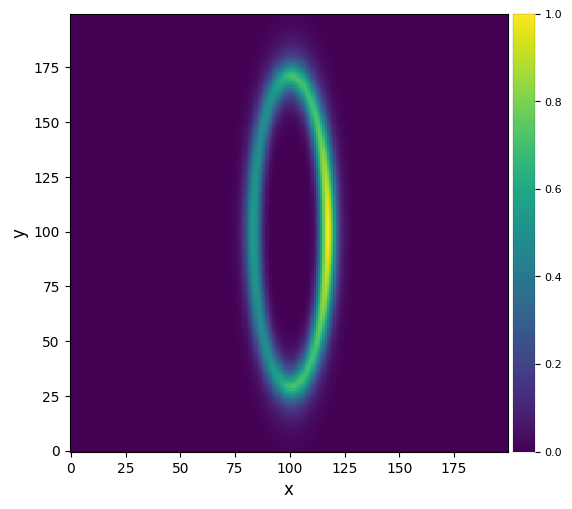

In [26]:
fake_disk5_map = fake_disk5.compute_scattered_light()
plot_frames(fake_disk5_map, grid=False, size_factor=6)

#### 6.2.3.4. Representing a polarised phase function

If you are trying to reproduce the polarised intensity of a disk (for instance Stokes $Q_\phi$ image), you may want to add on top of the scattering phase function, a modulation representing the degree of linear polarisation.

This can be done by setting the `polar` keyword to True and in this case, the model assumes a Rayleigh-like degree of linear polarisation parametrized by $(1-(\cos \phi)^2) / (1+(\cos \phi)^2)$ where $\phi$ is the scattering angle.

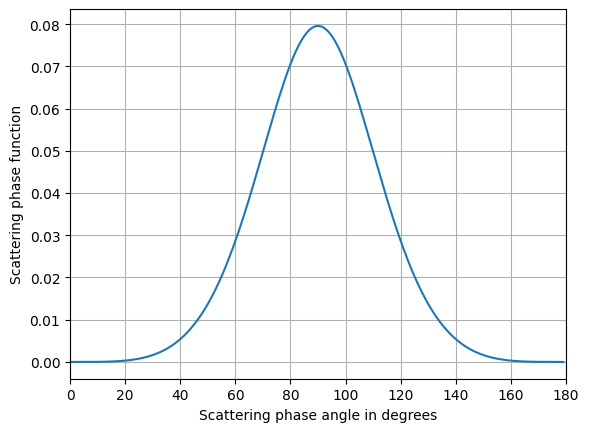

In [27]:
fake_disk6 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 
                                              'beta':beta, 'dens_at_r0':1e6},
                                spf_dico={'name':'HG', 'g':0, 'polar':True})
fake_disk6.phase_function.plot_phase_function()

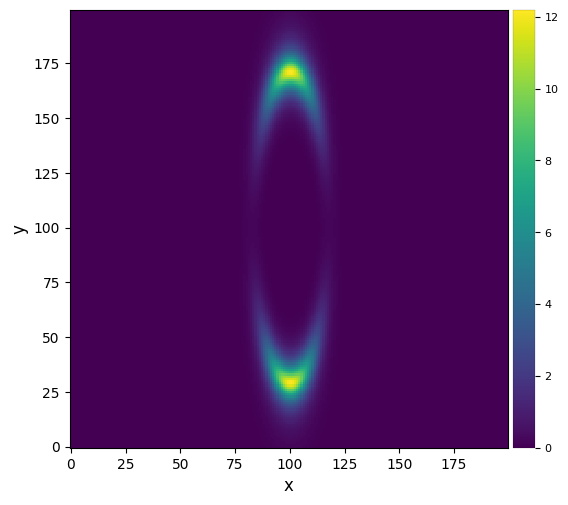

In [28]:
fake_disk6_map = fake_disk6.compute_scattered_light()
plot_frames(fake_disk6_map, grid=False, size_factor=6)

You can combine this Rayleigh-like degree of linear polarisation with any phase function (simple HG, double HG or custom type).

### 6.2.4. Asymmetric disk

Be careful here !

There is no consensus in the community on how to parametrize an eccentric dust distribution, so keep in mind that the convention described in section 1.2 is only one way to do so, but does not mean the dust density distribution in an eccentric disk follows this prescription. For instance, around the pericenter particle velocities are higher and one expects more collision to happen which can create an overdensity of particles compared to other regions of the disk. Conversely, particles stay longer at the apocenter because of Kepler's third law, which means that one could also expect a higher density at apocenter... All these physical phenomena are not described in this model.

Let's start woth a pole-on disk to be insensitive to phase function effects

In [29]:
e=0.4 # eccentricity in degrees
omega=30 # argument of pericenter

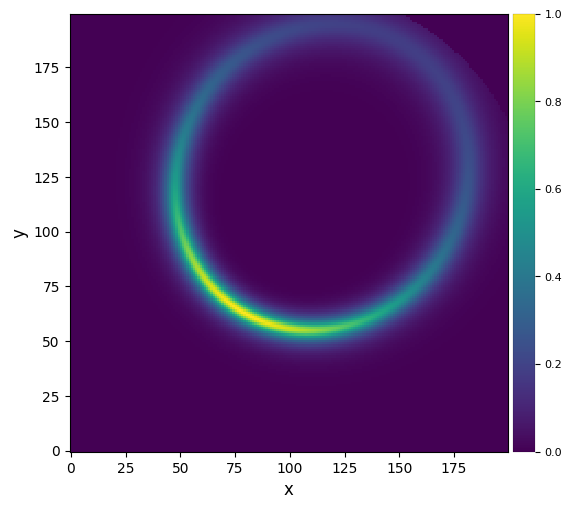

In [30]:
fake_disk7 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=0, omega=omega, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':e, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':g, 'polar':False},
                                flux_max=1.)
fake_disk7_map = fake_disk7.compute_scattered_light()
plot_frames(fake_disk7_map, grid=False, size_factor=6)

The brightness asymmetry here is entirely due to the fact that the brightness at one point in the disk is inversely proportional to the squared distance to the star.

Once you incline the disk, you start seeing the competing effect of the phase function and eccentricity.

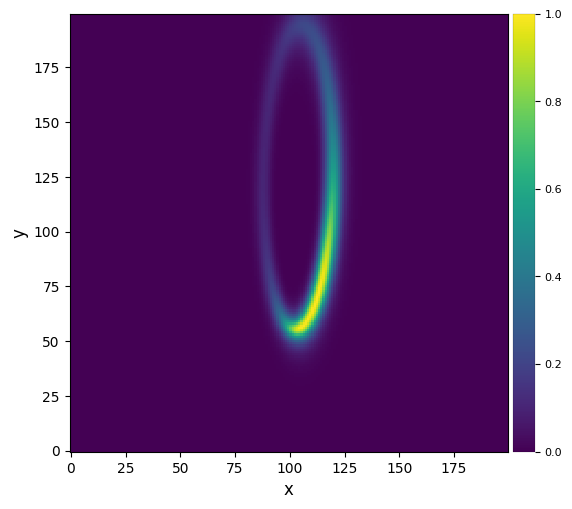

In [31]:
fake_disk7 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=omega, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':e, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':g, 'polar':False},
                                flux_max=1.)
fake_disk7_map = fake_disk7.compute_scattered_light()
plot_frames(fake_disk7_map, grid=False, size_factor=6)

## 6.3. Forward modeling of disks

Let's start from our inclined simple HG symmeric disk `fake_disk3_map` and assume we observe this disk as part of an ADI sequence of 30 images

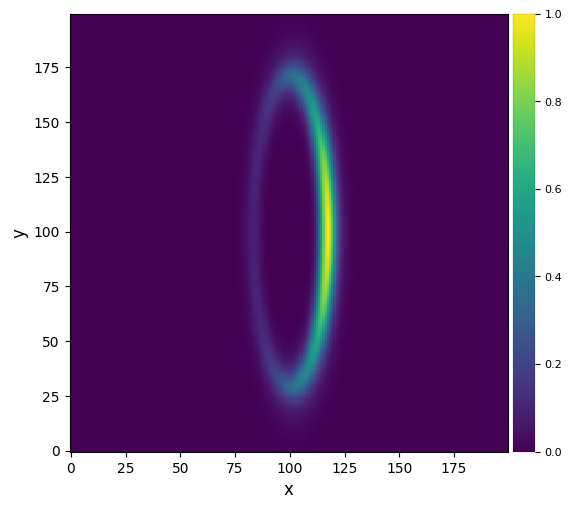

In [32]:
plot_frames(fake_disk3_map, grid=False, size_factor=6)

In [33]:
nframes = 30
# we assume we have 60º of parallactic angle rotation centered around meridian
parang_amplitude = 60
derotation_angles = np.linspace(-parang_amplitude/2, parang_amplitude/2, nframes)

In [34]:
start = time_ini()
cube_fake_disk3 = cube_inject_fakedisk(fake_disk3_map, -derotation_angles, imlib='vip-fft')
timing(start)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 17:34:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:09.281999
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


`cube_fake_disk3` is now a cube of 30 frames, where the disk has been injected at the correct position angle.

In [35]:
cube_fake_disk3.shape

(30, 200, 200)

Let's visualize the first, middle and last image of the cube.

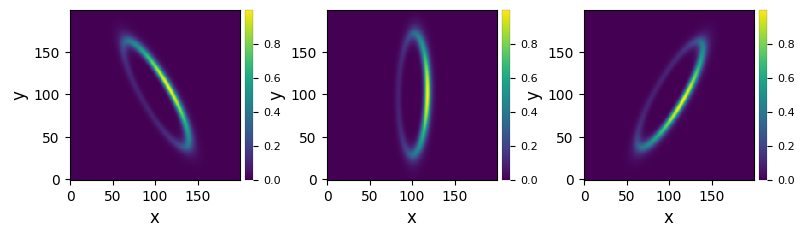

In [36]:
plot_frames((cube_fake_disk3[0], cube_fake_disk3[nframes//2], cube_fake_disk3[nframes-1]), 
            grid=False, size_factor=3)

We can now process this cube with median-ADI for instance:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 17:34:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:10.058605
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


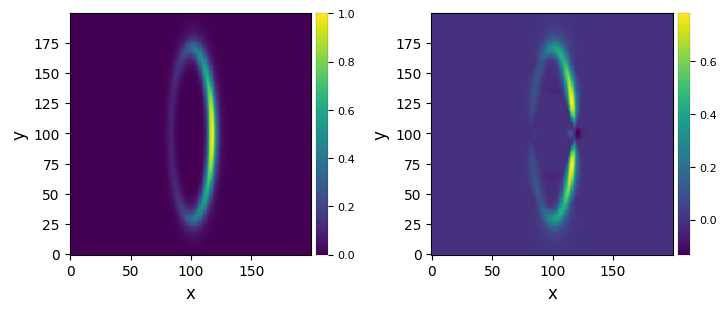

In [37]:
cadi_fake_disk3 = median_sub(cube_fake_disk3, derotation_angles, imlib='vip-fft')

plot_frames((fake_disk3_map, cadi_fake_disk3), grid=False, size_factor=4)

The example above shows a typical bias that can be induced by ADI on extended disk signals [(Milli et al. 2012)](https://ui.adsabs.harvard.edu/abs/2012A%26A...545A.111M/abstract).

So far we have not dealt with convolution effects. In practice the image of a disk is convolved by the instrumental PSF. 
Let's assume here an instrument having a gaussian PSF with FWHM = 4px, and create a synthetic PSF using the `create_synth_psf` function:

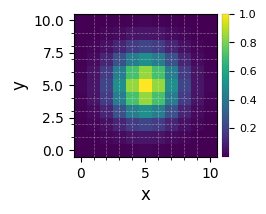

In [38]:
psf = create_synth_psf(model='gauss', shape=(11, 11), fwhm=4.)
plot_frames(psf, grid=True, size_factor=2)

Then we inject the disk in the cube and convolve each frame by the PSF

In [39]:
cube_fake_disk3_convolved = cube_inject_fakedisk(fake_disk3_map, -derotation_angles,
                                                 psf=psf, imlib='vip-fft')

Warning the PSF is not normalized to a total of 1. Normalization was forced.


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-02-09 17:34:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:09.268084
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


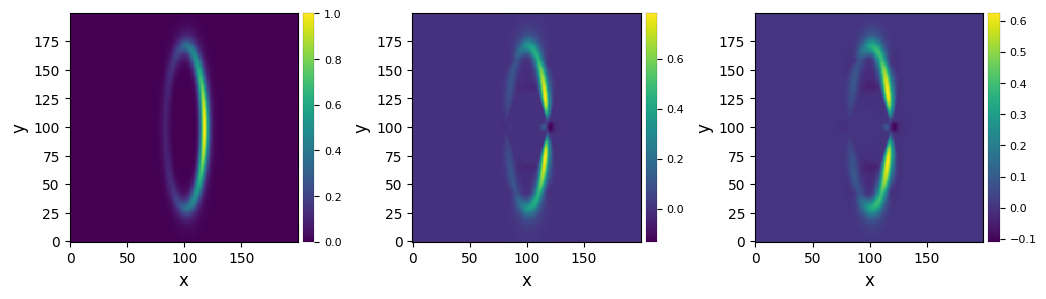

In [40]:
cadi_fake_disk3_convolved = median_sub(cube_fake_disk3_convolved, derotation_angles, imlib='vip-fft')

plot_frames((fake_disk3_map, cadi_fake_disk3, cadi_fake_disk3_convolved), grid=False, size_factor=4)

In practice, the synthetic cube is often used to subtract it to a real data cube in order to subtract the disk signal. The cube can then be reduced again and one iterates over the disk parameters in order to minimize the residuals after the ADI reduction. 

An alternative approach is to compute the forward model of the disk (right image above) and subtract the forward model image from the ADI image. This is easy in classical ADI or in PCA if one stores the principal components.